In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

In [82]:
# def set_seed(seed):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(42)
    
# def random_seed(seed_value, use_cuda):
#     np.random.seed(seed_value) # cpu vars
#     torch.manual_seed(seed_value) # cpu  vars
#     random.seed(seed_value) # Python
#     if use_cuda: 
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value) # gpu vars
#         torch.backends.cudnn.deterministic = True  #needed
#         torch.backends.cudnn.benchmark = False

# Image Classification

Steps:

* Load data into dataloaders
   - Presizing: Intuition is that we take a larger crop initially before doing transformations
2. check data loaded fine
3. train model
4. check results and see misclassifications
5. fix data if needed
6. define loss func cross entropy loss (softmax followed by negative log likelihood)
7. learning rate searching
8. train and test

## From Dogs and Cats to Pet Breeds

In [7]:
path = Path('/storage/data/oxford-iiit-pet/images')

In [5]:
example_image_path = get_image_files(path)[0]

In [6]:
example_image_path.name

'miniature_pinscher_199.jpg'

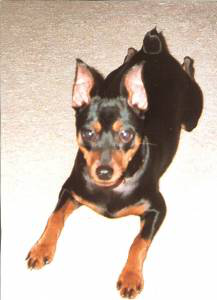

In [7]:
example_image = Image.open(example_image_path)
example_image

In [8]:
timg = tensor(example_image)
timg.shape

torch.Size([300, 217, 3])

In [9]:
example_image.size

(217, 300)

In [10]:
ex_img = PILImage.create(example_image_path)

In [11]:
r = Resize(460)
transformed_ex_img = r(ex_img)
tfms = aug_transforms(size=224, min_scale=0.75)

In [12]:
type(tfms[0])

fastai.vision.augment.Flip

In [13]:
timg = (tensor(example_image).clone() / 255).float()

In [14]:
doc(ImageBlock)

In [54]:
set_seed(42)

datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=240, min_scale=0.75),
    splitter=RandomSplitter(seed=42),
    get_items=partial(get_image_files,path),
#     get_items=lambda _ : [example_image_path, example_image_path],
    get_y=using_attr(RegexLabeller(r'(\w+)_\d+'), "name")
#     get_y=lambda x: x.name
)

set_seed(42)
dls = datablock.dataloaders(path)

In [55]:
# set_seed(42)
# dls.show_batch(max_n=5)

In [56]:
set_seed(42)
learner = vision_learner(dls, resnet18, metrics=error_rate)

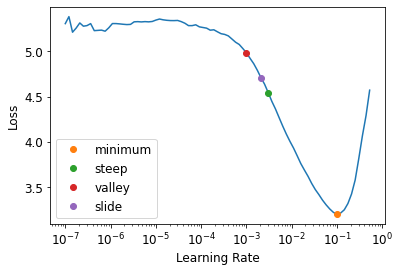

In [57]:
lr_min,lr_steep,lr_valley,lr_slide = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

SuggestedLRs(minimum=0.010000000149011612, steep=0.007585775572806597, valley=0.0005754399462603033, slide=0.0020892962347716093)

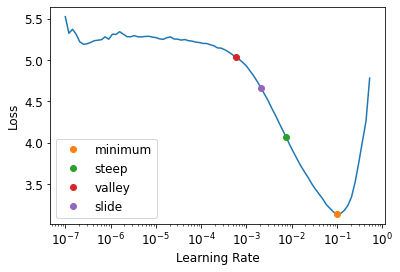

In [58]:
set_seed(42)
learner.fit_one_cycle()
learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [3]:
def create_learner(arch):
    datablock = DataBlock(
        blocks=(ImageBlock,CategoryBlock),
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=240, min_scale=0.75),
        splitter=RandomSplitter(seed=42),
        get_items=partial(get_image_files,path),
    #     get_items=lambda _ : [example_image_path, example_image_path],
        get_y=using_attr(RegexLabeller(r'(\w+)_\d+'), "name"))
    
    dls = datablock.dataloaders(path)
    
    learner = vision_learner(dls, arch, metrics=error_rate)
    return learner

In [19]:
def do_learning_one(learner, freeze_lr=1e-3, freeze_epochs = 3, epochs = 5, unfreeze_lr = slice(1e-3,1e-6)):
    # Train initially with freezing some epochs
    learner.fit_one_cycle(freeze_epochs,freeze_lr)
    
    # If we want to train all layers, pass `epochs` to number.
    # Here train wi
    if epochs:
        learner.unfreeze()
        # Now retrain existing weights with discriminative LR, starting
        # with a small value
        learner.fit_one_cycle(epochs, lr_max=unfreeze_lr)

In [5]:
def create_and_learn(arch, learning_func, **kwargs):
    learner = create_learner(arch)
    learning_func(learner, **kwargs)

In [21]:
with no_random():
    create_and_learn(resnet18, do_learning_one, freeze_epochs=1, epochs=1)

epoch,train_loss,valid_loss,error_rate,time
0,1.359640,0.455963,0.142760,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.887206,0.455184,0.147497,00:38


In [26]:
with no_random():
    learner = create_learner(resnet34)
    learner.fine_tune(5, base_lr=1e-3, freeze_epochs=3, lr_mult=1000)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.459216,1.099568,0.288904,00:44
1,1.297146,0.337921,0.102842,00:44
2,0.658202,0.269820,0.079838,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.380314,0.238481,0.071719,00:53
1,0.340240,0.227388,0.070365,00:54
2,0.263506,0.219234,0.064953,00:54
3,0.225613,0.197797,0.059540,00:54
4,0.206293,0.198360,0.057510,00:54


SuggestedLRs(minimum=0.012022644281387329, steep=0.004365158267319202, valley=0.0010000000474974513, slide=0.0020892962347716093)

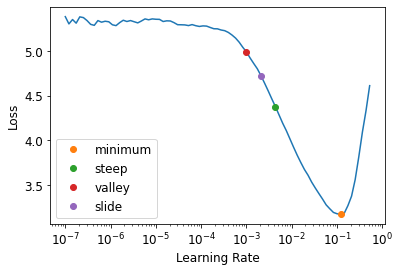

In [52]:
learner_18 = do_learning(resnet18)
learner_18.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [5]:
x = tensor(np.linspace(0, 50, 100))
y = torch.log(x)

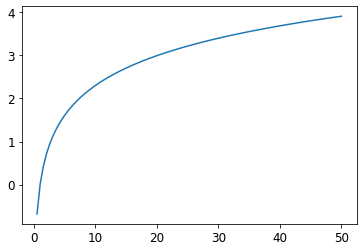

In [6]:
plt.plot(x, y, label='log')

In [50]:
x = tensor([10 ** x for x in range(-5, 5)])
x.s

tensor([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01, 1.0000e+00, 1.0000e+01, 1.0000e+02, 1.0000e+03, 1.0000e+04])

In [32]:
doc(plt.plot)

In [20]:
interpret = ClassificationInterpretation.from_learner(learner)

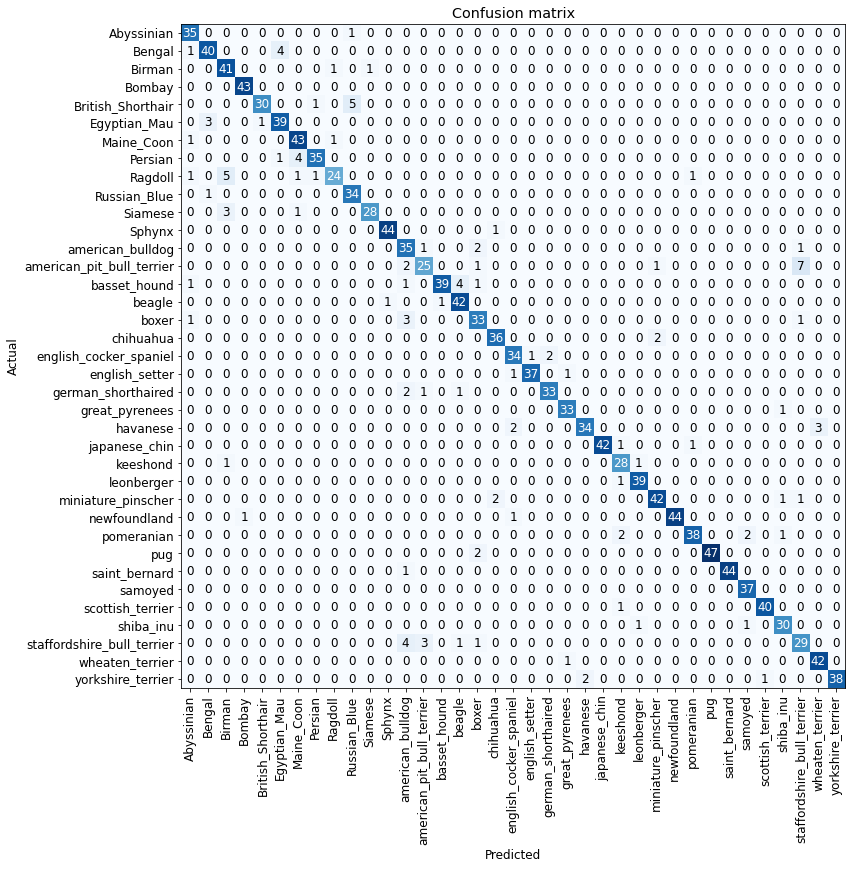

In [21]:
interpret.plot_confusion_matrix(figsize=(12,12))

### Checking and Debugging a DataBlock

## Cross-Entropy Loss

### Viewing Activations and Labels

### Softmax

### Log Likelihood

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

### Negative Log Likelihood

## Model Interpretation

## Improving Our Model

### The Learning Rate Finder

### Unfreezing and Transfer Learning

### Discriminative Learning Rates

### Selecting the Number of Epochs

### Deeper Architectures

## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

9. No, learning results will help clean data.


10. Softmax followed by Log


11. a. Sum of all probabilities is 1.

    b. Softmax amplifies the difference between predictions because of the exponential portion. Hence, it helps in nudging the algo to pick a particular class.
    
12. a. When you're not doing classification

    b. 
    
13. Done

14. torch.where takes just 2 categories as inputs

15. log isn't defined for -ve nums.

16. a. 1 order of magnitude less than minimum point on the loss vs lr curve
    b. Around the steepest point of the loss vs lr curve because this is where the loss is most heavily decreasing, so the algo is learning
    
17. a. Cuts off the head of the neural net and replaces with a new layer of random weights.
    b. Then it freezes the pre-trained layers for 1 epoch, while training just the new layer.
    c. Unfreezes the pre-trained layers and trains whole model
    
18. Using double question mark

19. Using a smaller learning rate to train the earlier layers and increasing gradually for the later layers is called discriminative LR. This is because the earlier layers learn much more general concepts which don't need much tweaking.

20. Used as a range to be used and divided into equal intervals where the 1st value is used as the learning rate for the earliest layer and then all the subsequent layers have increasing learning rates (which are "multiplicatively equidistant" from each other) until the last layer which has LR = 2nd value of slice.

21. Early stopping is not a great choice, because it doesn't allow the learning rate to get to the smaller values, which really helps with accuracy because that's what helps fine-tuning the weights.

22. 50 layers vs 101 layers

23. `to_fp16` allows the use of mixed precision (half point precision) where possible, which greatly improves the speed of training and also uses less memory.

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.